In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MQNLLKNLAASLGRKPFVADKQGVYRLTIDKHLVMLAPHGSELVLRTPIDAPMLREGNNVNVTLLRSLMQ QALAWAKRYPQTLVLDDYGQLVLEARLRLQELDTHGLQEVINKQLALLEHLIPQLTPFSVASRVGWN' #@param {type:"string"}
# @markdown - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
# @markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
# @markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname test_31f67
sequence MQNLLKNLAASLGRKPFVADKQGVYRLTIDKHLVMLAPHGSELVLRTPIDAPMLREGNNVNVTLLRSLMQQALAWAKRYPQTLVLDDYGQLVLEARLRLQELDTHGLQEVINKQLALLEHLIPQLTPFSVASRVGWN
length 137


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 155 ms, sys: 17.7 ms, total: 173 ms
Wall time: 45 s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2023-10-25 16:24:12,045 Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2023-10-25 16:24:12,047 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2023-10-25 16:24:14,904 Running on GPU
2023-10-25 16:24:15,078 Found 4 citations for tools or databases
2023-10-25 16:24:15,079 Query 1/1: test_31f67 (length 137)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


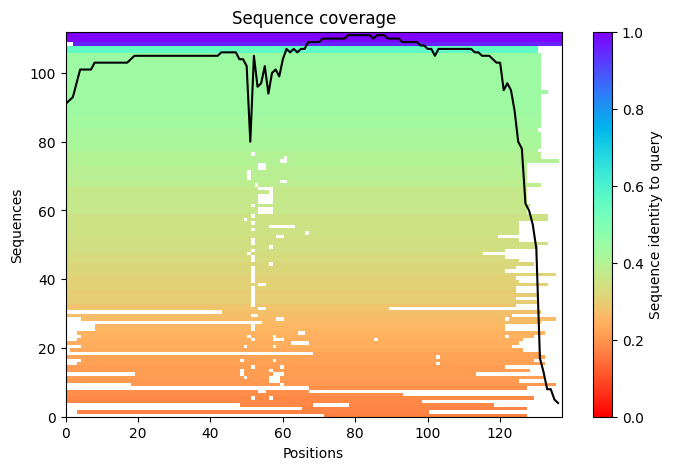

2023-10-25 16:24:16,339 Setting max_seq=112, max_extra_seq=1
2023-10-25 16:25:21,547 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=79.1 pTM=0.709
2023-10-25 16:25:24,439 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=83.9 pTM=0.755 tol=0.644
2023-10-25 16:25:27,344 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=83 pTM=0.742 tol=0.449
2023-10-25 16:25:30,244 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=83.9 pTM=0.751 tol=0.539
2023-10-25 16:25:30,245 alphafold2_ptm_model_1_seed_000 took 49.4s (3 recycles)


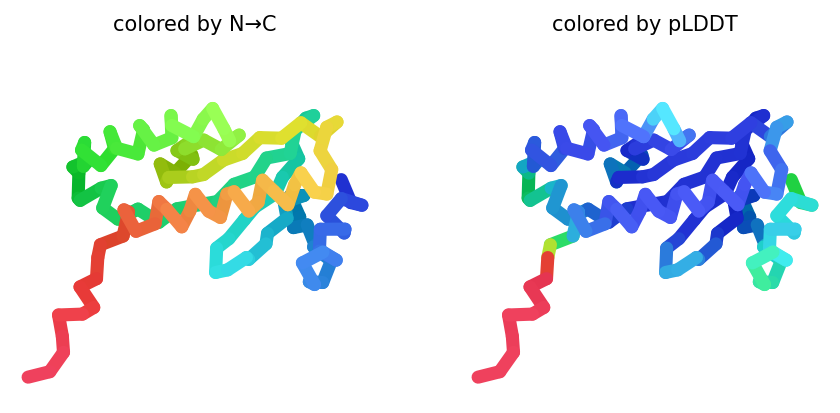

2023-10-25 16:25:33,734 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=84.5 pTM=0.766
2023-10-25 16:25:36,792 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=88 pTM=0.801 tol=0.795
2023-10-25 16:25:39,792 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=87.6 pTM=0.8 tol=0.354
2023-10-25 16:25:42,764 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=87.5 pTM=0.799 tol=0.0998
2023-10-25 16:25:42,765 alphafold2_ptm_model_2_seed_000 took 12.0s (3 recycles)


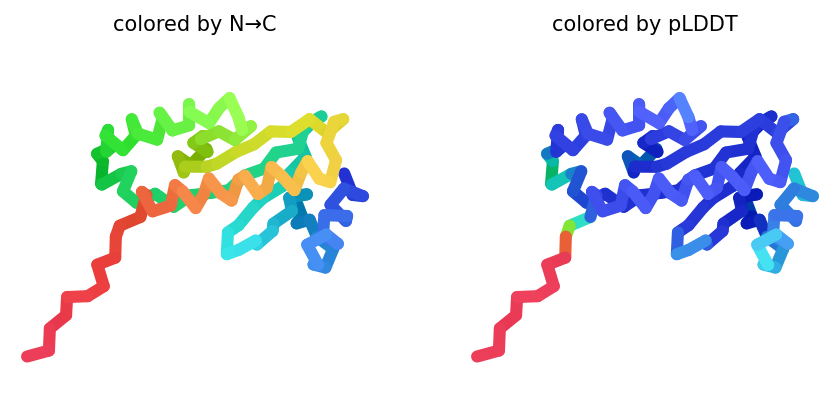

2023-10-25 16:25:46,115 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=85.6 pTM=0.777
2023-10-25 16:25:49,089 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=87 pTM=0.785 tol=0.671
2023-10-25 16:25:52,087 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=87.5 pTM=0.786 tol=0.308
2023-10-25 16:25:55,100 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=88.2 pTM=0.796 tol=0.177
2023-10-25 16:25:55,101 alphafold2_ptm_model_3_seed_000 took 12.0s (3 recycles)


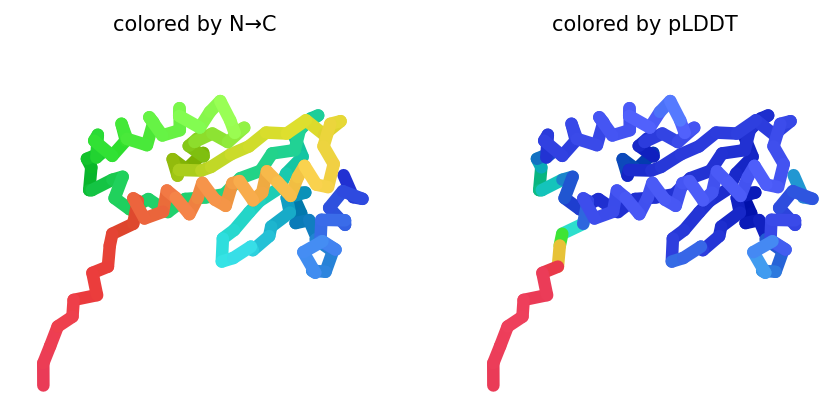

2023-10-25 16:25:58,412 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=84.9 pTM=0.779
2023-10-25 16:26:01,435 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=87.6 pTM=0.797 tol=0.789
2023-10-25 16:26:04,472 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=87.9 pTM=0.795 tol=0.284
2023-10-25 16:26:07,540 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=88.4 pTM=0.801 tol=0.228
2023-10-25 16:26:07,542 alphafold2_ptm_model_4_seed_000 took 12.1s (3 recycles)


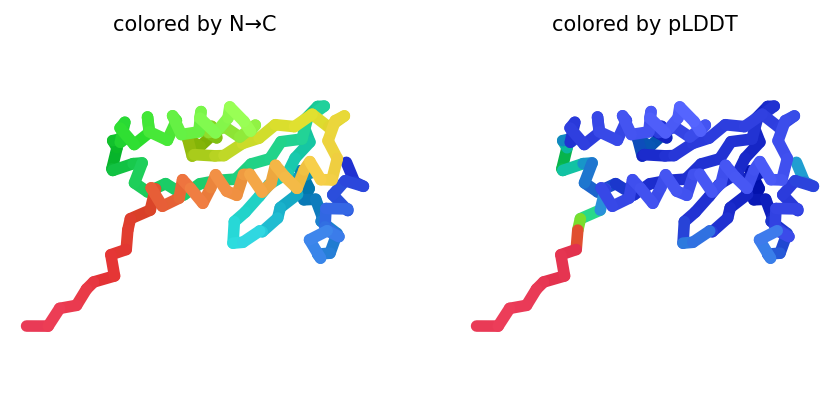

2023-10-25 16:26:10,944 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=82.1 pTM=0.756
2023-10-25 16:26:14,031 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=86.8 pTM=0.795 tol=0.869
2023-10-25 16:26:17,116 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=85.9 pTM=0.786 tol=0.262
2023-10-25 16:26:20,210 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=87.1 pTM=0.803 tol=0.269
2023-10-25 16:26:20,211 alphafold2_ptm_model_5_seed_000 took 12.4s (3 recycles)


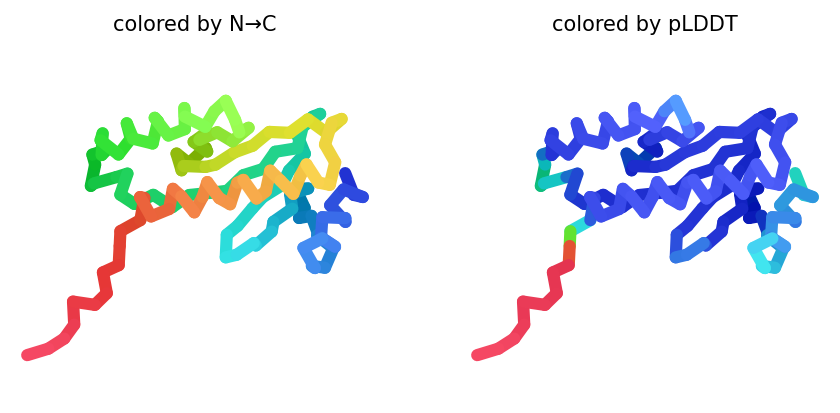

2023-10-25 16:26:20,426 reranking models by 'plddt' metric
2023-10-25 16:26:20,426 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=88.4 pTM=0.801
2023-10-25 16:26:20,428 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=88.2 pTM=0.796
2023-10-25 16:26:20,428 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=87.5 pTM=0.799
2023-10-25 16:26:20,429 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=87.1 pTM=0.803
2023-10-25 16:26:20,430 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=83.9 pTM=0.751
2023-10-25 16:26:23,421 Done


0

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

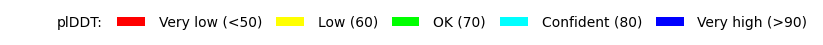

In [6]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


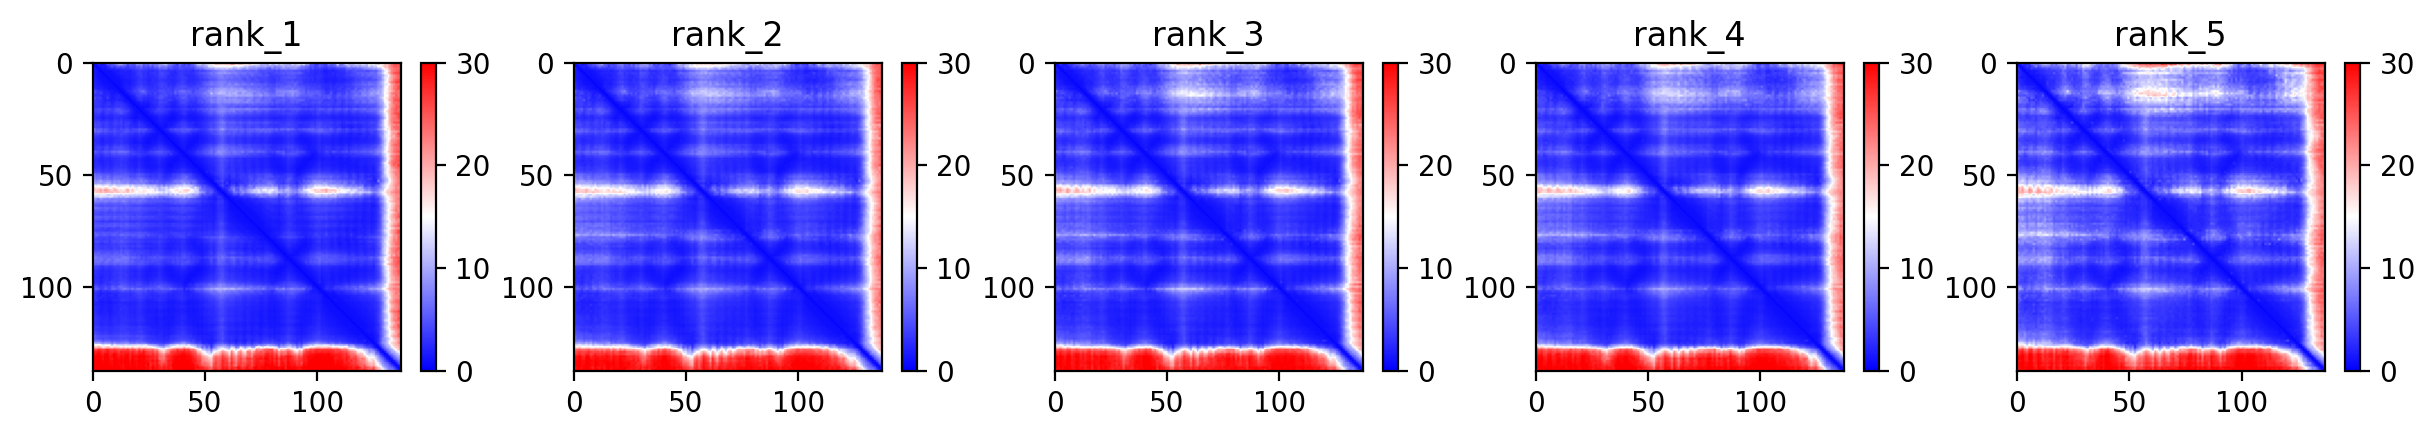
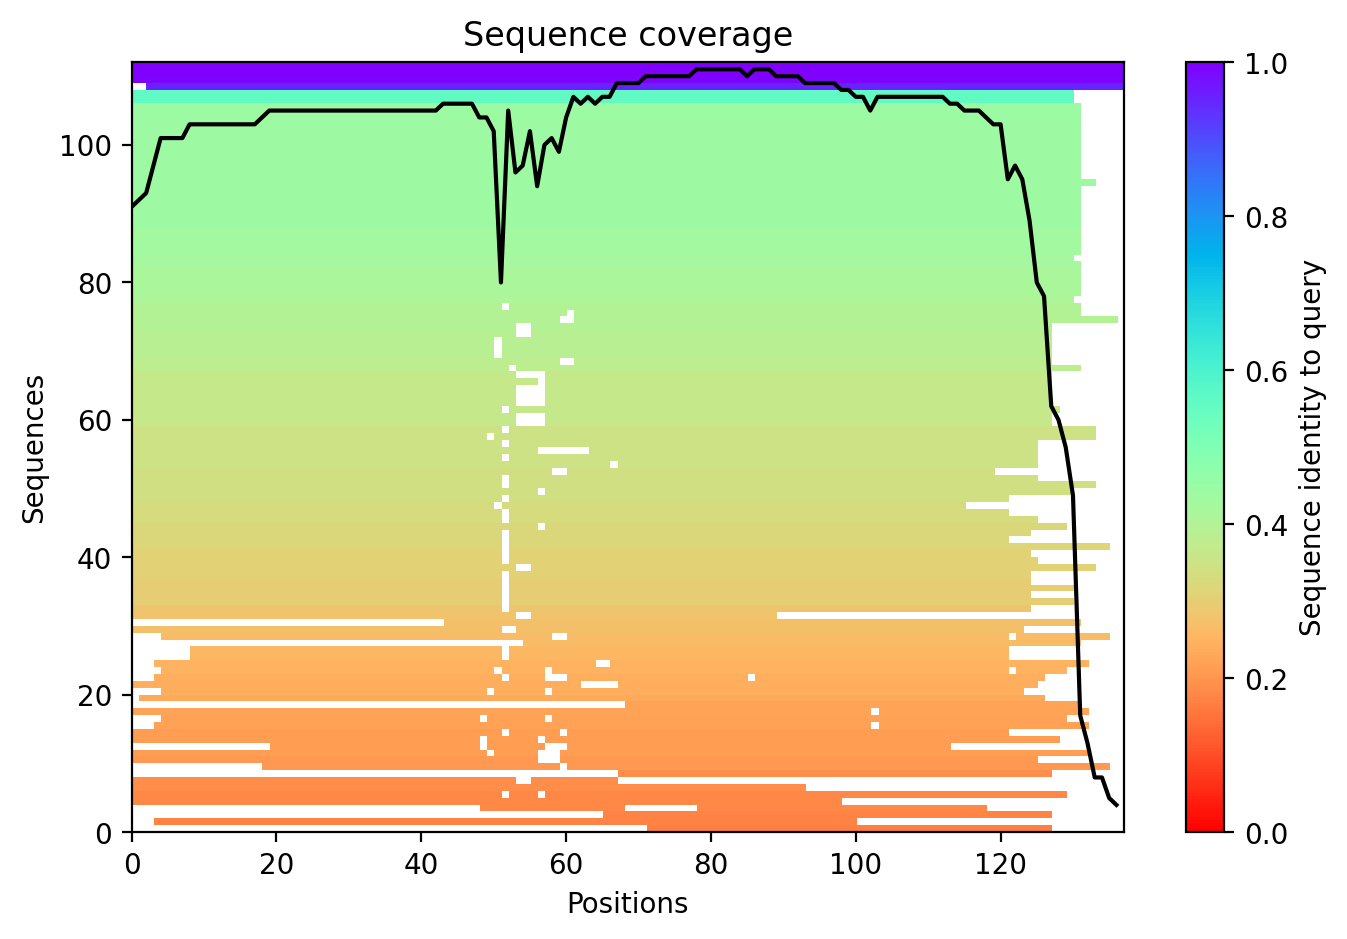
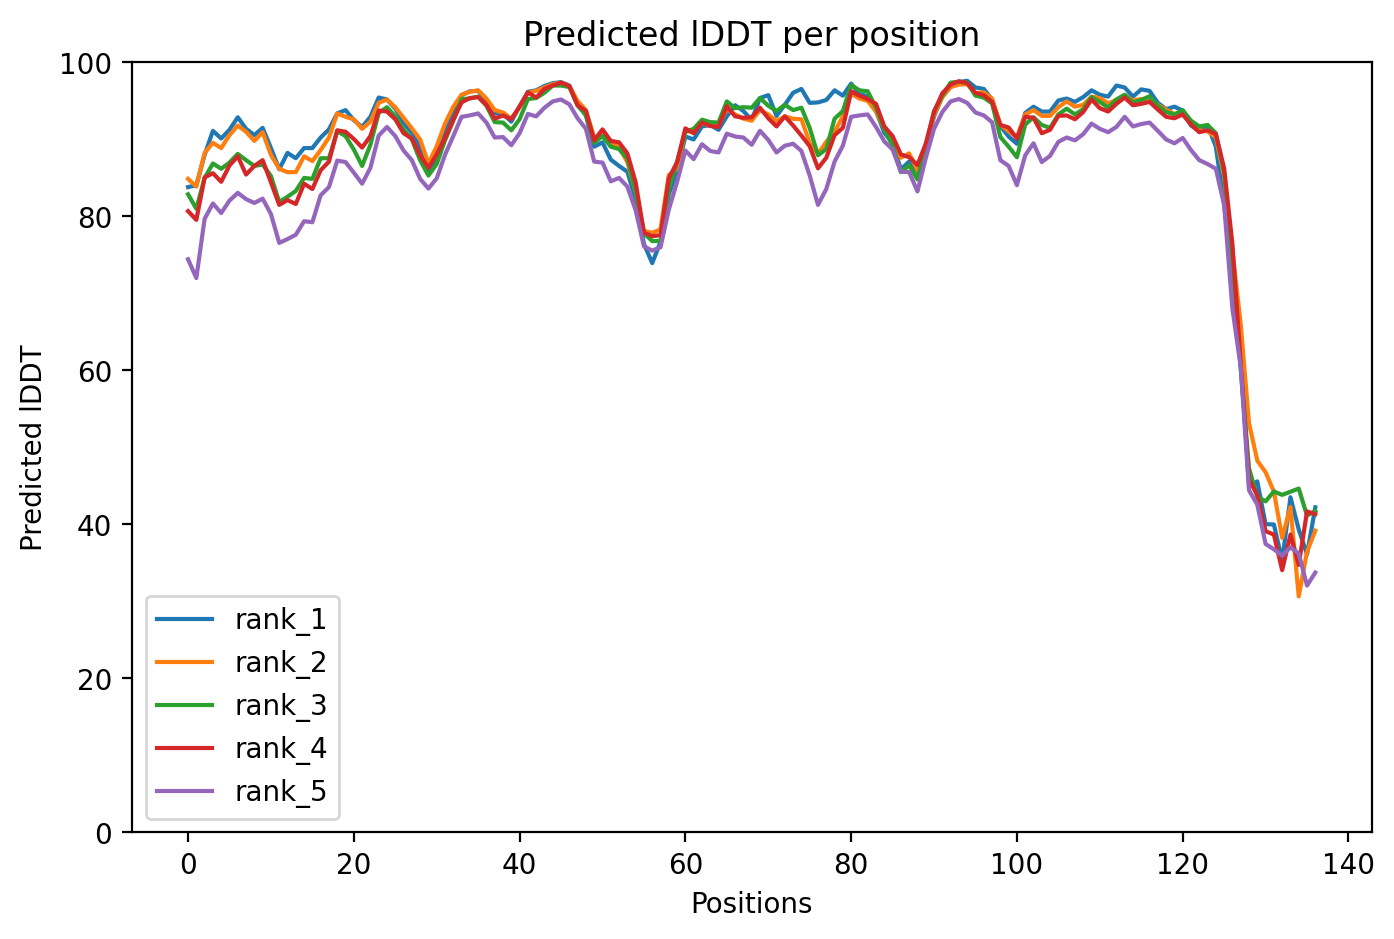

In [7]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


**Вывод**:
сравнивая две модели (настоящую и swiss) можно заметить разницу в скручивании, но в одном они похожи - удлинением в конце последовательности.